<a href="https://colab.research.google.com/github/Mifunoku/Analyze-amazon-cell-reviews/blob/main/Amazon_cell%26phone_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Info

product/productId: asin, e.g. amazon.com/dp/B00006HAXW

product/title: title of the product

product/price: price of the product

review/userId: id of the user, e.g. A1RSDE90N6RSZF

review/profileName: name of the user

review/helpfulness: fraction of users who found the review helpful

review/score: rating of the product

review/time: time of the review (unix time)

review/summary: review summary

review/text: text of the review


What to do?

1.   How length of review influence score
2.   sentiment analysis of score/review
3.  fake reviews
4.  najlepsze przedmioty do danej ceny
5.  zastanowic sie nad zmiana wartosci 0/3
6.  Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
  
cm = confusion_matrix(y_test, y_pred)





# Preprocessing, first analyze

In [211]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import spacy
import spacy.cli
import re
import nltk
from nltk import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from datetime import datetime, timedelta
from google.colab import drive


In [191]:
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [148]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [149]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [150]:
def parse(path):
  f = open(path, 'r')
  entry = {}
  for l in f:
    l = l.strip()
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry
 
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')
 


In [151]:
df = getDF('/content/drive/MyDrive/Cell_Phones_&_Accessories.txt')
df['review/score'] = df['review/score'].astype(float) 
df.head()

df['product/price']= df['product/price'].replace('unknown', np.nan)
df['product/price']= pd.to_numeric(df['product/price'], errors='ignore')
df['review/usefulness list'] = df['review/helpfulness'].apply(lambda x: x.split("/"))
df['review/usefulness'] = df['review/helpfulness'].apply(lambda x: eval(x.replace('/','*2-')))
df['review/time'] = pd.to_datetime(df['review/time'], unit='s')
df['review_length'] = df['review/text'].apply(lambda x: len(x))

in this analyze we suspect that if helpfulness is 6/10 it means that 6 ppl thinks thats helpfull, and 4 thinks thats useless, so we can balance it and say that 2 ppl agree to that opinion

In [152]:
df.head()

,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/usefulness list,review/usefulness,review_length
0,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,NaN,A1RXYH9ROBAKEZ,A. Igoe,0/0,1.0,2009-01-31,Don't buy!,"First of all, the company took my money and se...","[0, 0]",0,716
1,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,NaN,A7L6E1KSJTAJ6,Steven Martz,0/0,5.0,2007-10-04,Mobile Action Bluetooth Mobile Phone Tool Soft...,Great product- tried others and this is a ten ...,"[0, 0]",0,164
2,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,NaN,A2NOQQ7I6PU7CW,"Daniel M. Johnson ""rocknbluesharp""",0/0,4.0,2007-08-10,good,works real good....a little hard to set up...w...,"[0, 0]",0,146
3,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",NaN,A29Q0CLOF0U8BN,E. Owens,4/5,4.0,2006-04-28,No instructions included...,The price was right for this cable ($11.95+$4....,"[4, 5]",3,1340
4,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",NaN,ANNHJND2MHUI3,"Isaac Salas ""=CRBF=gB^link""",0/0,1.0,2007-03-12,NOT A DATA CABLE,this is NOT a DATA CABLE this is only a USB ch...,"[0, 0]",0,66


In [ ]:
df.info()

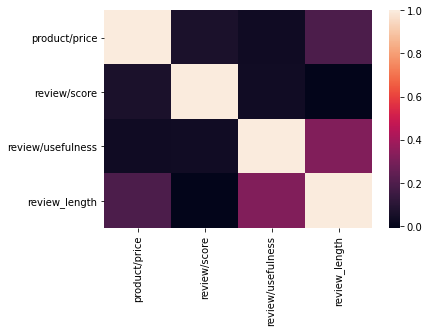

In [153]:
sns.heatmap(df.corr())

In [154]:
title = df['review/summary']
title = title.str.lower()
# removing special characters and numbers
title = title.apply(lambda x : re.sub("[^a-z\s]","",x) )
stopwords = set(stopwords.words("english"))
#removing stopwords
title = title.apply(lambda x : " ".join(word for word in x.split() if word not in stopwords ))

all_words = ' '.join([text for text in title])
all_words = all_words.split()
fdist = FreqDist(all_words)
words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

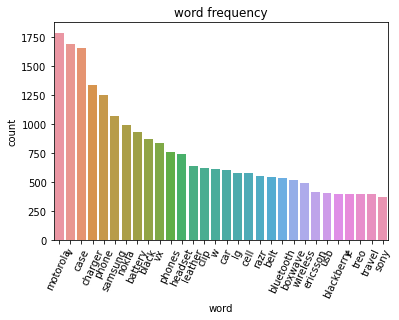

In [213]:
g = sns.barplot(data=words_df.nlargest(columns="count", n = 30) , x= "word", y = "count")
plt.title('word frequency')
plt.xticks(rotation=65)

created weighted mean to increase impact of helpfull opinion.

for example review with 4/6 helpfulness will have 4-(6-4)=2 2+1(it's own) = 3, so weight 3

There are df summed and summed2.

summed is df where param review/usefulness is greater than 0

in summed2 there are all entries

In [156]:
usefull_reviews = df.copy()
usefull_reviews = usefull_reviews[usefull_reviews['review/usefulness']>=0]
usefull_reviews['review/usefulness'] = usefull_reviews['review/usefulness']+1
usefull_reviews['value'] = usefull_reviews['review/score']*usefull_reviews['review/usefulness']


summed = pd.DataFrame(usefull_reviews['product/productId'].value_counts())
summed.columns = ['count']
summed['name'] = usefull_reviews.groupby('product/productId')['product/title'].unique()
summed['name'] = summed['name'].apply(lambda x : x[0])
summed['val_sum'] = usefull_reviews.groupby('product/productId')['value'].sum() 
summed['weight_sum'] = usefull_reviews.groupby('product/productId')['review/usefulness'].sum()
summed['weighted_mean'] = round(summed['val_sum'] / summed['weight_sum'], 2)
summed['mean'] = round(usefull_reviews.groupby('product/productId')['review/score'].mean(), 2)
summed['price'] = usefull_reviews.groupby('product/productId')['product/price'].mean()
summed.drop(['val_sum',	'weight_sum'],inplace=True, axis = 1)
summed

,count,name,weighted_mean,mean,price
B0009B0IX4,3247,Plantronics Voyager 510 Bluetooth Headset [Ret...,4.03,4.24,89.99
B0007WWAGI,885,Motorola HS850 Bluetooth Headset (Color Sent B...,3.35,3.40,29.99
B000GAO9T2,771,Samsung WEP200 Bluetooth Wireless Phones Heads...,4.06,3.89,NaN
B000RUPEOA,563,Jawbone Noise Shield Bluetooth Headset (Black)...,2.83,3.18,56.90
B000CQXHOS,552,Motorola H700 Bluetooth Headset [Motorola Reta...,3.83,3.70,NaN
...,...,...,...,...,...
B000MQQPWE,1,As Seen on TV Antenna Booster,1.00,1.00,0.89
B000N4C0Q0,1,Rim BlackBerry Pearl 8100 PDA Smart Phone Soli...,5.00,5.00,NaN
B000CR3X2I,1,Speck Skin Tight Case for Motorola RAZR (pink),2.00,2.00,NaN
B0009HJWT4,1,T-Mobile MDA III / O2 XDA IIs / Siemens SX66 /...,4.00,4.00,NaN


In [157]:
summed2 = pd.DataFrame(df['product/productId'].value_counts())
summed2.columns = ['count']
summed2['name'] = df.groupby('product/productId')['product/title'].unique()
summed2['name'] = summed2['name'].apply(lambda x : x[0])
summed2['mean'] = round(df.groupby('product/productId')['review/score'].mean(), 2)
summed2['price'] = df.groupby('product/productId')['product/price'].mean()
summed2

,count,name,mean,price
B0009B0IX4,3443,Plantronics Voyager 510 Bluetooth Headset [Ret...,4.16,89.99
B0007WWAGI,984,Motorola HS850 Bluetooth Headset (Color Sent B...,3.35,29.99
B000GAO9T2,848,Samsung WEP200 Bluetooth Wireless Phones Heads...,3.81,NaN
B000CQXHOS,628,Motorola H700 Bluetooth Headset [Motorola Reta...,3.53,NaN
B000RUPEOA,623,Jawbone Noise Shield Bluetooth Headset (Black)...,3.20,56.90
...,...,...,...,...
B000055ZOM,1,Nokia Limited Edition Donald Duck Faceplate fo...,5.00,NaN
B000EU166S,1,Cell Phone Emergency Charger,1.00,NaN
B000GM40OY,1,Motorola Q Monaco Flip Type Leather Case - Black,3.00,NaN
B0000AKAGR,1,Motorola Lithium Ion 800mA Battery High Perfor...,5.00,NaN


In [158]:
categ = summed2['name']
categ = categ.str.lower()
categ = categ.apply(lambda x : re.sub("[^a-z\s]","",x) )
categ = categ.apply(lambda x : " ".join(word for word in x.split() if word not in stopwords ))
all_words = ' '.join([text for text in categ])
all_words = all_words.split()
fdist = FreqDist(all_words)
words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

Here are the most frequent words in title section, after that I picked brands and create list of them and then categorize every review


In [159]:
words_df.nlargest(columns="count", n = 50)


,word,count
6,motorola,1785
53,v,1687
141,case,1655
109,charger,1337
46,phone,1251
18,samsung,1063
256,nokia,984
82,battery,927
13,black,869
167,vx,829


In [160]:
marks = ['htc', 'sony', 'blackberry', 'ericsson', 'lg', 'nokia', 'samsung', 'motorola']

# categorize

In [161]:
def check(z,marks):
  '''
  :param z: z is sentence
  :param marks: its list of categories
  function returns category from marks or create new - "noname"
  '''
  z = z.lower()
  a = list(set(marks).intersection(set(z.split())))
  if len(a)==1:
    return a[0]
  elif len(a)==2:
    model = a[0]+' '+a[1]
    if model in ['ericsson sony', 'sony ericsson', 'motorola blackberry']:
      return model
    else:
      return 'noname'
  else:
    return 'noname'
  #elif len(a)>2: there are some gadgets matching a lot of models, but we don't want to categorize them example is
  '''brand new universal horizontal slim eva pouch leather case with belt 
  clip of lg lx-550, cu500, vx-8700, motorola
   razr v3, v3c, v3m, v3i, samsung a900, t809, d807, a990,
    t629, sch-u740, sanyo 6600'''


summed2['category'] = summed2['name'].apply(lambda x : check(x, marks))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

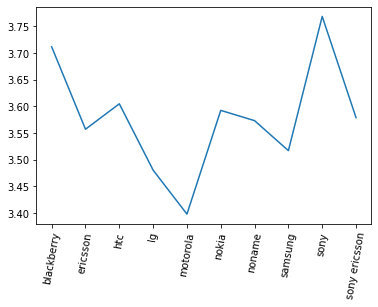

In [162]:
df['category'] = df['product/title'].apply(lambda x : check(x, marks))
plt.plot(df.groupby('category')['review/score'].mean())

plt.xticks(rotation=80)

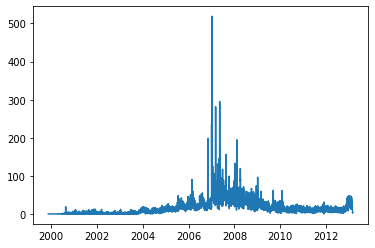

In [163]:

plt.plot(df.groupby('review/time').size())

we can see that in 2007-2009 were bigger interest


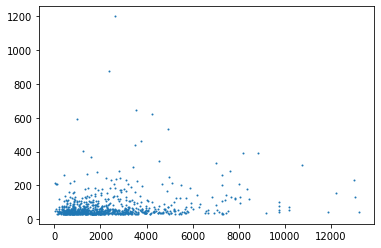

In [164]:
plt.scatter(df['review_length'][df['review/usefulness']>30],df['review/usefulness'][df['review/usefulness']>30],s=1)


The most valuable opinions are between 100-4000 signs

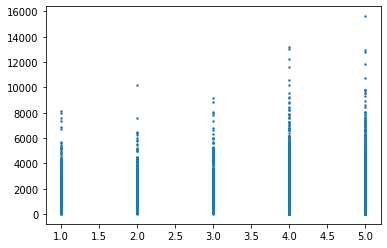

In [206]:
plt.scatter(df['review/score'],df['review_length'], s=2)

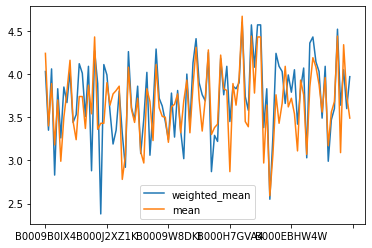

In [166]:
summed[:100].plot( y =['weighted_mean','mean'])

In [167]:
text_df = pd.DataFrame([])
text_df["review"] = df['review/text']
text_df["summary"] = df['review/summary']
text_df["is_neg"] = df['review/score'].apply(lambda x: 1 if x < 3 else 0) # we classify 1,2 as negative, and 3,4,5 as positive. we could also drop 3 and makes positive- 4,5
text_df['opinion_connected'] = text_df["review"]+' ' + text_df["summary"]
text_df

,review,summary,is_neg,opinion_connected
0,"First of all, the company took my money and se...",Don't buy!,1,"First of all, the company took my money and se..."
1,Great product- tried others and this is a ten ...,Mobile Action Bluetooth Mobile Phone Tool Soft...,0,Great product- tried others and this is a ten ...
2,works real good....a little hard to set up...w...,good,0,works real good....a little hard to set up...w...
3,The price was right for this cable ($11.95+$4....,No instructions included...,0,The price was right for this cable ($11.95+$4....
4,this is NOT a DATA CABLE this is only a USB ch...,NOT A DATA CABLE,1,this is NOT a DATA CABLE this is only a USB ch...
...,...,...,...,...
78925,I got this headset because I like the SonyEric...,"great sound quality, good battery life, averag...",0,I got this headset because I like the SonyEric...
78926,I have owned this product for over two weeks n...,Excellent quality at an affordable price,0,I have owned this product for over two weeks n...
78927,I bought this item for my husband. He really l...,Sony Ericsson Bluetooth HBH-PV700 Headset - DP...,0,I bought this item for my husband. He really l...
78928,I bought this item after I shopped in the loca...,"works great, competitively priced",0,I bought this item after I shopped in the loca...


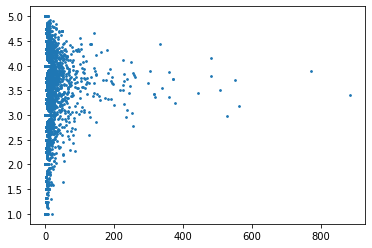

In [210]:
a=summed.copy() #remove one bigger entry with count equal around 3500
a=a[a['count']<1500]
plt.scatter(a['count'], a['mean'],s=3)

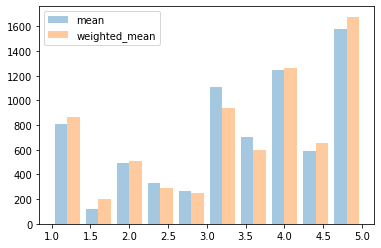

In [169]:
plt.hist([summed['mean'],summed['weighted_mean']], alpha = 0.4)
plt.legend(['mean','weighted_mean'])

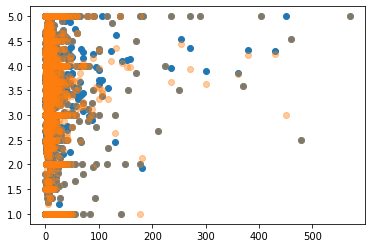

In [170]:
plt.scatter(summed['price'], summed['mean'])
plt.scatter(summed2['price'], summed2['mean'],alpha=0.4)

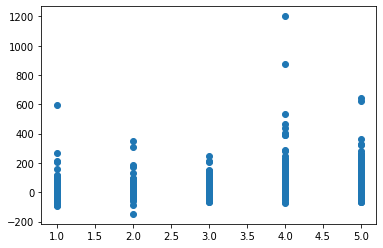

In [171]:
plt.scatter(df['review/score'],df['review/usefulness'])

# ML analyze

In [172]:
text_df["is_neg"].mean()

0.2817813252248828

## Count Vectorizer

In [173]:
X = text_df["opinion_connected"] #reviews
y = text_df["is_neg"] #negative


X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25, random_state=0)


vect = CountVectorizer()
vect.fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized=vect.transform(X_test)

### CV LogReg

In [174]:
LogReg = LogisticRegression(max_iter=10000)
LogReg.fit(X_train_vectorized,y_train)

y_pred = LogReg.predict(X_test_vectorized)
print("Accuracy on df test data is : %0.2f" %(accuracy_score(y_test, y_pred)*100))
print(confusion_matrix(y_test, y_pred))

Accuracy on df test data is : 88.21
[[13150  1005]
 [ 1321  4257]]


Accuracy on df test data is : 88.20
[[13149  1006]
 [ 1322  4256]]

Improve CV LogReg using GridSearch

In [ ]:
# LogReg = LogisticRegression(max_iter=10000)
# parameters = dict(C = [0.0001, 0.001, 0.01,0.1, 1],)

# clf=GridSearchCV(LogReg2, parameters)
# clf.fit(X_train_vectorized,y_train)
# print(clf.best_estimator_)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [175]:
LogReg2 = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

LogReg2.fit(X_train_vectorized,y_train)

y_pred = LogReg2.predict(X_test_vectorized)
print("Accuracy on df test data is : %0.2f" %(accuracy_score(y_test, y_pred)*100))
print(confusion_matrix(y_test, y_pred))

Accuracy on df test data is : 88.47
[[13207   948]
 [ 1328  4250]]


In [176]:
LogReg2 = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

LogReg2.fit(X_train_vectorized,y_train)

y_pred = LogReg2.predict(X_test_vectorized)
print("Accuracy on df test data is : %0.2f" %(accuracy_score(y_test, y_pred)*100))
print(confusion_matrix(y_test, y_pred))

Accuracy on df test data is : 88.61
[[13255   900]
 [ 1347  4231]]


In [177]:

print('AUC: ',roc_auc_score(y_test,y_pred))

AUC:  0.8474669118815795


### positive and negative coeffiecients

In [178]:
feature_names = np.array(vect.get_feature_names())

#sort the coffecient from the LogReg.
sorted_coef_index = LogReg.coef_[0].argsort()

print('Smallest Coefficient(Negative reviews): \n{}\n'.format(feature_names[sorted_coef_index[-20:]]))
print('Largest Coeffiecient(Positive reviews): \n{}'.format(feature_names[sorted_coef_index[:20]]))

Smallest Coefficient(Negative reviews): 
['ordinary' 'hill' 'useless' 'rubbish' 'horrible' 'somesome' 'hopes'
 'junk' 'defeats' 'worst' 'v60g' 'profit' 'paperweight' 'worthless'
 'unreliable' 'unacceptable' 'unusable' 'waste' 'dissapointment' 'garbage']

Largest Coeffiecient(Positive reviews): 
['revision' 'solved' 'beats' 'awesome' 'dln' 'served' 'keeper' 'iam'
 'messenger' 'loves' 'surprisingly' 'checkout' 'excellent' 'drawback'
 'excelent' 'outstanding' 'asia' 'amazing' 'suits' 'elegant']


### CV Random Forest

In [180]:
model = RandomForestClassifier()
model.fit(X_train_vectorized, y_train) 

y_pred = model.predict(X_test_vectorized)
print("Accuracy on df test data is : %0.2f" %(accuracy_score(y_test, y_pred)*100))
print(confusion_matrix(y_test, y_pred))

Accuracy on df test data is : 82.03
[[13985   170]
 [ 3377  2201]]


Accuracy on df test data is : 82.08
[[13986   169]
 [ 3367  2211]]

### CV KNN

In [181]:
model = KNeighborsClassifier()
model.fit(X_train_vectorized, y_train) 

y_pred = model.predict(X_test_vectorized)
print("Accuracy on df test data is : %0.2f" %(accuracy_score(y_test, y_pred)*100))
print(confusion_matrix(y_test, y_pred))

Accuracy on df test data is : 76.11
[[13422   733]
 [ 3981  1597]]


## NLP with Spacy


In this case spacy is not efficient. Long time processing and lower score than cv

In [192]:
nlp = spacy.load('en_core_web_lg')

In [193]:
opinions = text_df["opinion_connected"]
opinions.head().tolist()

["First of all, the company took my money and sent me an email telling me the product was shipped. A week and a half later I received another email telling me that they are sorry, but they don't actually have any of these items, and if I received an email telling me it has shipped, it was a mistake.When I finally got my money back, I went through another company to buy the product and it won't work with my phone, even though it depicts that it will. I have sent numerous emails to the company - I can't actually find a phone number on their website - and I still have not gotten any kind of response. What kind of customer service is that? No one will help me with this problem. My advice - don't waste your money! Don't buy!",
 "Great product- tried others and this is a ten compared to them. Real easy to use and sync's easily. Definite recommended buy to transfer data to and from your Cell. Mobile Action Bluetooth Mobile Phone Tool Software MA-730",
 'works real good....a little hard to set

Clean Data

In [195]:
opinions = opinions.str.lower()
# removing special characters and numbers
opinions = opinions.apply(lambda x : re.sub("[^a-z\s]","",x) )
#removing stopwords
opinions = opinions.apply(lambda x : " ".join(word for word in x.split() if word not in stopwords ))

In [196]:
doc_df = nlp.pipe(opinions)
opinions_vector_df = np.array([opinion.vector for opinion in doc_df])

In [197]:
X = opinions_vector_df
y = text_df["is_neg"]
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)
print("Accuracy on df test data is : %0.2f" %(accuracy_score(y_test, y_pred)*100))
y_train_pred = LogReg.predict(X_train)
print("Accuracy on df train data is : %0.2f" %(accuracy_score(y_train, y_train_pred)*100))
print(confusion_matrix(y_test, y_pred))

Accuracy on df test data is : 85.38
Accuracy on df train data is : 85.44
[[13159   996]
 [ 1888  3690]]


In [198]:
print('AUC: ',roc_auc_score(y_test, y_pred))

AUC:  0.795581800075206


### SVM.svc

In [212]:
model = SVC()
model.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)
print("Accuracy on df test data is : %0.2f" %(accuracy_score(y_test, y_pred)*100))
y_train_pred = LogReg.predict(X_train)
print("Accuracy on df train data is : %0.2f" %(accuracy_score(y_train, y_train_pred)*100))
print(confusion_matrix(y_test, y_pred))

Accuracy on df test data is : 85.38
Accuracy on df train data is : 85.44
[[13159   996]
 [ 1888  3690]]


# Sentiment analyze using vader

In [199]:
sid = SentimentIntensityAnalyzer()
text_df["sentiments_all"] = text_df['opinion_connected'].apply(lambda x: sid.polarity_scores(x))


In [200]:
text_df['compound_all']  = text_df["sentiments_all"].apply(lambda score_dict: score_dict['compound'])
text_df['compound_all']  = text_df["compound_all"].apply(lambda c: 0 if c >=0 else 1)
text_df['sid'] = np.where(text_df["is_neg"] == text_df["compound_all"], True, False)
text_df.head()

,review,summary,is_neg,opinion_connected,sentiments_all,compound_all,sid
0,"First of all, the company took my money and se...",Don't buy!,1,"First of all, the company took my money and se...","{'neg': 0.063, 'neu': 0.879, 'pos': 0.058, 'co...",1,True
1,Great product- tried others and this is a ten ...,Mobile Action Bluetooth Mobile Phone Tool Soft...,0,Great product- tried others and this is a ten ...,"{'neg': 0.0, 'neu': 0.706, 'pos': 0.294, 'comp...",0,True
2,works real good....a little hard to set up...w...,good,0,works real good....a little hard to set up...w...,"{'neg': 0.041, 'neu': 0.852, 'pos': 0.107, 'co...",0,True
3,The price was right for this cable ($11.95+$4....,No instructions included...,0,The price was right for this cable ($11.95+$4....,"{'neg': 0.043, 'neu': 0.859, 'pos': 0.097, 'co...",0,True
4,this is NOT a DATA CABLE this is only a USB ch...,NOT A DATA CABLE,1,this is NOT a DATA CABLE this is only a USB ch...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0,False


In [201]:
text_df["sid"].value_counts(normalize = True)

True     0.809502
False    0.190498
Name: sid, dtype: float64

## Second try dropping neutral 3.0 score

In [ ]:
text_df2 = pd.DataFrame([])
text_df2["review"] = df['review/text']
text_df2["summary"] = df['review/summary']
text_df2["is_neg"] = df['review/score']
text_df2 = text_df2[text_df2['is_neg'] != 3.0]
text_df2["is_neg"] = text_df2["is_neg"].apply(lambda x: 1 if x < 3 else 0)
text_df2['opinion_connected'] = text_df["review"]+' ' + text_df["summary"]

text_df2["sentiments_all"] = text_df2['opinion_connected'].apply(lambda x: sid.polarity_scores(x))
text_df2['compound_all']  = text_df2["sentiments_all"].apply(lambda score_dict: score_dict['compound'])
text_df2['compound_all']  = text_df2["compound_all"].apply(lambda c: 0 if c >=0 else 1)


In [218]:
text_df2['sid'] = np.where(text_df2["is_neg"] == text_df2["compound_all"], True, False)
text_df2["sid"].value_counts(normalize = True)

True     0.818504
False    0.181496
Name: sid, dtype: float64

result is similar to previous when we categorize 3 as positive

# Trending

In [202]:
df.head()

,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/usefulness list,review/usefulness,review_length,category
0,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,NaN,A1RXYH9ROBAKEZ,A. Igoe,0/0,1.0,2009-01-31,Don't buy!,"First of all, the company took my money and se...","[0, 0]",0,716,noname
1,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,NaN,A7L6E1KSJTAJ6,Steven Martz,0/0,5.0,2007-10-04,Mobile Action Bluetooth Mobile Phone Tool Soft...,Great product- tried others and this is a ten ...,"[0, 0]",0,164,noname
2,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,NaN,A2NOQQ7I6PU7CW,"Daniel M. Johnson ""rocknbluesharp""",0/0,4.0,2007-08-10,good,works real good....a little hard to set up...w...,"[0, 0]",0,146,noname
3,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",NaN,A29Q0CLOF0U8BN,E. Owens,4/5,4.0,2006-04-28,No instructions included...,The price was right for this cable ($11.95+$4....,"[4, 5]",3,1340,noname
4,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",NaN,ANNHJND2MHUI3,"Isaac Salas ""=CRBF=gB^link""",0/0,1.0,2007-03-12,NOT A DATA CABLE,this is NOT a DATA CABLE this is only a USB ch...,"[0, 0]",0,66,noname


In [203]:
def trending(day='2007-02-16',date=df, days_to_subtract=10, no_sold=10, score=4.0):
  '''
  :param day: day when we wants show trending products in format "%Y-%m-%d"
  :param date: dateframe of reviews
  :param days_to_subtract: how many days back we are taking under revision
  :param no_sold: number of sold items from (day-days_to_subtract to day) to qualify as trending
  :param score: score over to qualify as trending
  returns products id 
  '''
  day =datetime.strptime(day, "%Y-%m-%d")
  d = day - timedelta(days=days_to_subtract)

  df1=date[(d<=date['review/time']) & (date['review/time']<=day)]
  sum = pd.DataFrame(df1['product/productId'].value_counts())
  sum['mean'] = round(df1.groupby('product/productId')['review/score'].mean(), 2)
  sum = sum[sum['product/productId']>=no_sold]
  sum = sum[sum['mean']>=score]
  
  return sum.index
print(trending())


Index(['B0009B0IX4'], dtype='object')


# Recomended in category

In [188]:
def recommended(df = summed, nor_valid=10, no_best=5):
  '''
  :param df: DataFrame from we are taking data
  :param nor_valid: review is valid over this number of reviews
  :param no_best: return no_best best products in every category
  return recommended product id's under given information in every category
  '''

  df['category'] = df['name'].apply(lambda x : check(x, marks))
  df = df.sort_values(['category', 'mean'],ascending=False)
  df = df[df['count']>nor_valid] #review will be valid if there is more than 10 reviews
  recommended = df.groupby('category')['mean'].nlargest(no_best)

  return recommended
recommended()

category                 
blackberry     B000FFEH04    4.87
               B000FEHG76    4.85
               B000OEMIZM    4.57
               B000ROCJ2Q    4.55
               B000MUP62A    4.47
ericsson       B000055ZON    3.92
               B000I2TPGU    3.73
               B0000ARS2K    3.73
               B000I2S2EG    3.67
htc            B000BT0VF4    4.42
               B000N38FI8    4.39
               B000I1XLG6    4.17
               B000M564WG    4.15
               B000N38FHE    4.13
lg             B000EA0HVI    4.83
               B000IVA024    4.64
               B000JCP0S6    4.63
               B000JFLDWK    4.58
               B000HZY7AW    4.56
motorola       B000FI7230    4.91
               B0003031WG    4.86
               B000BX7Q1C    4.78
               B000FHBEFS    4.77
               B000BQOOQ4    4.77
nokia          B00004W77R    4.93
               B0009RFX24    4.82
               B000JJH2VW    4.80
               B000IVDI4Q    4.74
               B000JCS

## recomended in category under price

In [228]:
def recommended_under_price(df = summed, nor_valid=10, no_best=5,price=100):
  '''
  :param df: DataFrame from we are taking data
  :param nor_valid: review is valid over this number of reviews
  :param no_best: return no_best best products in every category
  :param price: products under this price will return
  return recommended product id's under given information in every category
  '''
  df.dropna()
  df= df[df['price']<price]
  df['category'] = df['name'].apply(lambda x : check(x, marks))
  df = df.sort_values(['category', 'mean'],ascending=False)
  df = df[df['count']>nor_valid] #review will be valid if there is more than 10 reviews
  recommended = df.groupby('category')['mean'].nlargest(no_best)

  return recommended
recommended_under_price().sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


category                 
nokia          B00004W77R    4.93
motorola       B000FI7230    4.91
noname         B000F6OJHE    4.91
blackberry     B000FFEH04    4.87
motorola       B0003031WG    4.86
lg             B000EA0HVI    4.83
nokia          B0009RFX24    4.82
noname         B000NRD0UC    4.82
nokia          B000JJH2VW    4.80
motorola       B000FHBEFS    4.77
nokia          B000IVDI4Q    4.74
noname         B000IBF5PG    4.73
               B00008NGK0    4.71
               B000059MZ7    4.71
samsung        B000PQ2SBI    4.69
motorola       B000PYN9JA    4.64
lg             B000JCP0S6    4.63
motorola       B00074JWH6    4.62
samsung        B000J2D9TS    4.62
lg             B000JFLDWK    4.58
sony ericsson  B0009SHMUY    4.56
blackberry     B000ROCJ2Q    4.55
lg             B000QFQDPA    4.53
nokia          B0008JEJBO    4.47
samsung        B000FDXH8E    4.46
blackberry     B000LAD42A    4.45
               B000JZ96XI    4.42
htc            B000BT0VF4    4.42
               B000N38

# Best products with over 30 reviews

In [189]:
def best_overall(df = df, nor_valid=30, no_best=10):
  '''
  :param df: DataFrame from we are taking data
  :param nor_valid: review is valid over this number of reviews
  :param no_best: return no_best best products
  return best products under given information
  '''
  usefull_reviews = df.copy()
  usefull_reviews = usefull_reviews[usefull_reviews['review/usefulness']>=0]
  usefull_reviews['review/usefulness'] = usefull_reviews['review/usefulness']+1
  summed = pd.DataFrame(usefull_reviews['product/productId'].value_counts())
  summed.columns = ['count']
  summed['mean'] = round(usefull_reviews.groupby('product/productId')['review/score'].mean(), 2)
  summed = summed[summed['count']>nor_valid]
  summed = summed['mean'].nlargest(no_best)

  return summed
best_overall()

B000FEHG76    4.85
B000FHBEFS    4.77
B000IVDI4Q    4.74
B000059MZ7    4.71
B00008NGK0    4.71
B000059MYY    4.71
B00004WHF4    4.71
B000059MZ2    4.71
B000IUYY2W    4.71
B000BHAUSE    4.68
Name: mean, dtype: float64